In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Snippet for the use of relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Imports

from src.data.make_dataset import get_split_data, getNormalizedProjectedData

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score

import graphviz
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, validation_curve, train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from src.data.make_dataset import X, Y
from src.visualization.visualize import plotConfusionMatrix

# Supervised Learning

## Decision Trees

In [4]:
X_norm = getNormalizedProjectedData(components=2)
X_train, X_test, y_train, y_test = get_split_data(features=X_norm, test_size=0.2)

In [5]:
tree_clf = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

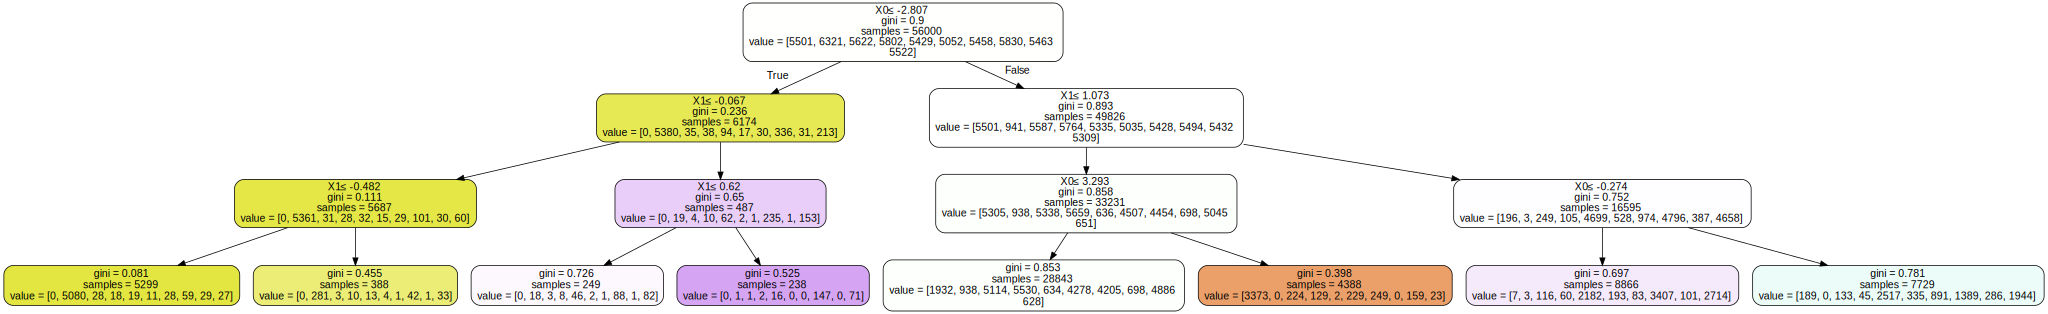

In [6]:
dot_data = export_graphviz(tree_clf, out_file=None, 
                    filled=True, rounded=True,  
                    special_characters=True)  
                    
graph = graphviz.Source(dot_data)  
graph 

In [9]:
X_train, X_test, y_train, y_test = get_split_data(test_size=0.2)
tree_clf = DecisionTreeClassifier(max_depth=10).fit(X_train, y_train)

In [12]:


train_preds = tree_clf.predict(X_train)
val_preds = tree_clf.predict(X_test)

print(f'Training accuracy : {accuracy_score(train_preds, y_train):.2f}')
print(f'Test accuracy : {accuracy_score(val_preds, y_test):.2f}')

Training accuracy : 0.90
Test accuracy : 0.85


In [22]:


training_accuracies = []
test_accuracies = []

for depth in range(1, 20):
    clf = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)

    train_preds = clf.predict(X_train)
    val_preds = clf.predict(X_test)

    training_accuracies.append(accuracy_score(train_preds, y_train))
    test_accuracies.append(accuracy_score(val_preds, y_test))


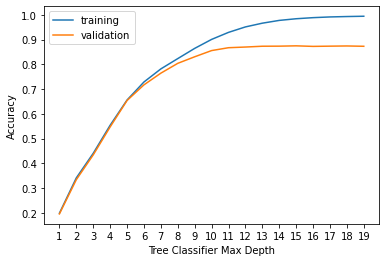

In [30]:
plt.plot(training_accuracies)
plt.plot(test_accuracies)

plt.ylabel('Accuracy')
plt.xlabel('Tree Classifier Max Depth')
plt.xticks([i for i in range(0,19)], [i for i in range(1,20)])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

## Support Vector Machines

In [7]:
X_norm = Normalizer().fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size = 0.1, train_size=0.2,random_state = 42)

In [5]:
linear_svc = SVC(kernel='linear').fit(X_train, y_train)

In [6]:
y_pred = linear_svc.predict(X_test)

In [7]:
print(f'Test accuracy : {accuracy_score(y_pred, y_test):.2f}')

Test accuracy : 0.93


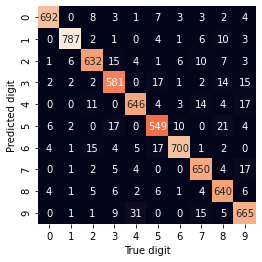

In [8]:
plotConfusionMatrix(y_pred, y_test)

### GridSearch Cross Validation for hyperparameter tuning on RBF Kernel SVC

In [11]:
X_red = getNormalizedProjectedData(components=87)
X_train, X_test, y_train, y_test = train_test_split(X_red, Y, test_size = 0.2, train_size=0.4, random_state = 42)
X_train.shape

(28000, 87)

In [42]:
# Hyperparameter tuning with grid search cross validation
Cs = [0.01, 0.1, 1, 10]
gammas = [0.01, 0.1, 1]

hyperparameters = dict(C=Cs, gamma=gammas)

rbf_svc = SVC(kernel='rbf')

rbf_svc_cv = GridSearchCV(estimator=rbf_svc, param_grid=hyperparameters, scoring='accuracy', cv=3, verbose=3,return_train_score=True)

rbf_svc_cv.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.01, gamma=0.01 ..............................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  C=0.01, gamma=0.01, score=(train=0.870, test=0.870), total= 1.9min
[CV] C=0.01, gamma=0.01 ..............................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s
[CV]  C=0.01, gamma=0.01, score=(train=0.870, test=0.865), total= 1.8min
[CV] C=0.01, gamma=0.01 ..............................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.5min remaining:    0.0s
[CV]  C=0.01, gamma=0.01, score=(train=0.871, test=0.870), total= 1.8min
[CV] C=0.01, gamma=0.1 ...............................................
[CV]  C=0.01, gamma=0.1, score=(train=0.199, test=0.197), total= 2.6min
[CV] C=0.01, gamma=0.1 ...............................................
[CV]  C=0.01, gamma=0.1, score=(train=0.198, test=0.

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=3)

In [43]:
print(f'Best parameters {rbf_svc_cv.best_params_} give a score of {rbf_svc_cv.best_score_:.2f}')

Best parameters {'C': 10, 'gamma': 0.01} give a score of 0.97


In [86]:
# Plotting the grid search results as line plots (could also be heatmap)
# ref : https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
        ax.fill_between(grid_param_1, scores_mean[idx,:]+scores_sd[idx,:], scores_mean[idx,:]-scores_sd[idx,:], alpha=0.2)

    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Mean Accuracy', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    plt.xscale('log')
    ax.grid('on')

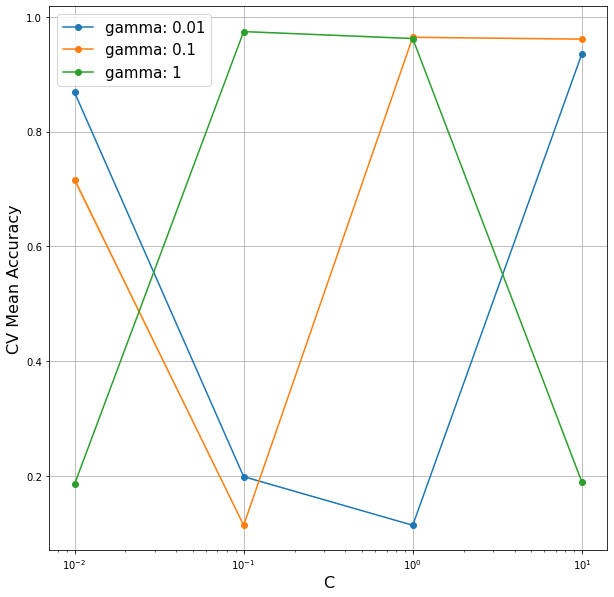

In [87]:
plot_grid_search(rbf_svc_cv.cv_results_, Cs, gammas, 'C', 'gamma')

## Gaussian Naive Bayes

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size = 0.2, random_state = 42)

gnb = GaussianNB().fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

print(f'Test accuracy : {accuracy_score(y_pred_gnb, y_test):.2f}')

Test accuracy : 0.58


## Influence of PCA on SVM performance

Fitting the model with 2 features
Fitting the model with 5 features
Fitting the model with 10 features
Fitting the model with 87 features


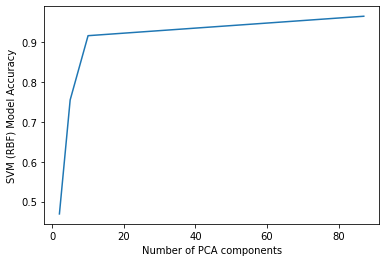

In [3]:
# We will use 5 different training sets with different number of PCA components
n_components_ = [2, 5, 10, 87]
pca_scores = []

for n_comp in n_components_:
    print(f'Fitting the model with {n_comp} features')
    # Preprocessing
    X_red = getNormalizedProjectedData(components=n_comp)
    X_train, X_test, y_train, y_test = train_test_split(X_red, Y, test_size = 0.2, random_state = 42)

    # Model Training
    model = SVC(C=0.1, kernel='rbf').fit(X_train, y_train)

    # Model Evaluation
    y_pred = model.predict(X_test)
    pca_scores.append(accuracy_score(y_pred, y_test))


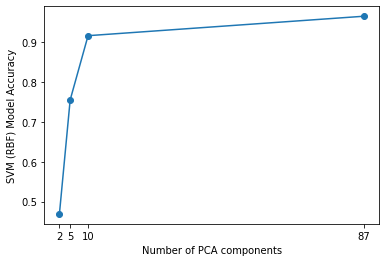

In [6]:
plt.plot(n_components_, pca_scores, marker='o')
plt.xlabel('Number of PCA components')
plt.ylabel('SVM (RBF) Model Accuracy')
plt.xticks(n_components_)
plt.show()